In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import odr
from scipy.optimize import curve_fit
from scipy.stats import chi2

In [125]:
# Preamble:
plt.rc('text', usetex=True)
plt.rc("axes", labelsize=18)
plt.rc("xtick", labelsize=18, top=True, direction="in")
plt.rc("ytick", labelsize=18, right=True, direction="in")
plt.rc("axes", titlesize=18)
plt.rc("legend", fontsize=15)
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3

In [2]:
#Funktioner til at finde peaks
def slope_max(slope,volt,intensity): 
    volt_slope = volt[slope[0]:slope[1]+1]
    intensity_slope = intensity[slope[0]:slope[1]+1]
    unique_volt = np.array(sorted(list(set(volt_slope))))
    slope_int = np.array([np.mean([intensity_slope[i] for i,volt_j in enumerate(volt_slope) if volt_j == volt_i]) for volt_i in unique_volt])
    max_peaks = find_peaks(slope_int,distance=1,width=1)[0]
    min_peaks = find_peaks(-1*slope_int,distance=1,width=1)[0]
    int_to_sort = np.append(slope_int[max_peaks],slope_int[min_peaks])
    volt_to_sort = np.append(unique_volt[max_peaks],unique_volt[min_peaks])
    filter_list = np.argsort(volt_to_sort)
    return int_to_sort[filter_list],volt_to_sort[filter_list]


def max_several_files(max_file_num,file_name): 
    rise_max = []
    fall_max = []
    rise_volts = []
    fall_volts = []
    
    for i in range(max_file_num): 
        print(i)
        
        if i < 9: 
            time,intensity,volt = load_file(f'{file_name}_0{i+1}')
        else: 
            time,intensity,volt = load_file(f'{file_name}_{i+1}')
        if len(volt) < 1000:
            continue 
        else: 
            max_peaks = find_peaks(volt,distance=1000,width=100)[0]
            min_peaks = find_peaks(-1*volt,distance=1000,width=100)[0]
            rise_slopes,fall_slopes = find_slopes(max_peaks,min_peaks)

            for rise in rise_slopes:
                int_max,volt_max = slope_max(rise,volt,intensity)
                if len(volt_max) == 10:
                    rise_max.append(int_max)
                    rise_volts.append(volt_max)
                #print(f'Rise:{len(volt_max)}')
                
            for fall in fall_slopes: 
                int_max,volt_max = slope_max(fall,volt,intensity)
                if len(volt_max) == 10:
                    fall_max.append(int_max)
                    fall_volts.append(volt_max)
                #print(f'Fall:{len(volt_max)}')
            
    rise_mean = np.mean(rise_max,axis=0)
    rise_error = np.std(rise_max,ddof=1,axis=0)/np.sqrt(len(rise_max))
    fall_mean = np.mean(fall_max,axis=0)
    fall_error = np.std(fall_max,ddof=1,axis=0)/np.sqrt(len(fall_max))
    volt_rise_mean = np.mean(rise_volts,axis=0)
    rise_volt_error = np.std(rise_volts,ddof=1,axis=0)/np.sqrt(len(rise_volts))
    volt_fall_mean = np.mean(fall_volts,axis=0)
    fall_volt_error = np.std(fall_volts,ddof=1,axis=0)/np.sqrt(len(fall_volts))
    print(f'Nr. of datapoints: {len(rise_max)}')
    return volt_rise_mean,rise_volt_error,volt_fall_mean,fall_volt_error,rise_mean,rise_error,fall_mean,fall_error


In [3]:
#volt_rise,volt_rise_error,volt_fall,volt_fall_error,rise_max,\
#rise_max_error,fall_max,fall_max_error = max_several_files(10,'Dag2_2')

In [66]:
def load_file(name): 
    #data = np.loadtxt('data/Test2/' + name + '.csv',skiprows=2,delimiter=',').T 
    data = np.loadtxt('E:\Eksperimentel_fysik\Michelson_interferometer\\' + name + '.csv',skiprows=2,delimiter=',').T
    return data

def find_slopes(top, bot):
    rise = []
    fall = []
    first_rising = top[0] > bot[0]          
    last_rising = top[-1] > bot[-1]
    max_len = max(len(top), len(bot))
    if first_rising and last_rising:
        fall = [(top[i], bot[i+1]) for i in range(max_len - 1)]
        rise = [(bot[i], top[i] ) for i in range(max_len)]
    elif first_rising and not last_rising:
        fall = [(top[i], bot[i+1]) for i in range(max_len - 1)]
        rise = [(bot[i],top[i]) for i in range(max_len - 1)]
    elif not first_rising and not last_rising:
        fall = [(top[i], bot[i]) for i in range(max_len)]
        rise = [(bot[i],top[i+1]) for i in range(max_len - 1)]
    elif not first_rising and last_rising:
        fall = [(top[i], bot[i]) for i in range(max_len - 1)]
        rise = [(bot[i],top[i+1]) for i in range(max_len -1)]
    else:
        print('You fucked it up fam')
    return rise, fall

def slope_intensity(slope,volt,intensity): 
    volt_slope = volt[slope[0]:slope[1]+1]
    intensity_slope = intensity[slope[0]:slope[1]+1]
    unique_volt = sorted(list(set(volt_slope)))
    slope_int = [np.mean([intensity_slope[i] for i,volt_j in enumerate(volt_slope) if volt_j == volt_i]) for volt_i in unique_volt]
    return slope_int, unique_volt

def mean_slopes(slope_list,volt,intensity): 
    slope_ints = []
    for slope in slope_list: 
        s_int,unique_volt = slope_intensity(slope,volt,intensity)
        slope_ints.append(s_int)
    mean_slope = np.mean(slope_ints,axis=0)
    error_slope = np.std(slope_ints,axis=0,ddof=1)/np.sqrt(len(slope_ints))
    return unique_volt,mean_slope,error_slope

def mean_several_files(max_file_num,file_name,N,to_print=False): 
    rise_ints = []
    fall_ints = []
    volt_to_return = []
    for i in range(max_file_num): 
        print(i)
        
        if i < 9: 
            time,intensity,volt = load_file(f'{file_name}_0{i+1}')
        else: 
            time,intensity,volt = load_file(f'{file_name}_{i+1}')
        if len(volt) < 1000:
            continue 
        else: 
            max_peaks = find_peaks(volt,distance=1000,width=100)[0]
            min_peaks = find_peaks(-1*volt,distance=1000,width=100)[0]
            rise_slopes,fall_slopes = find_slopes(max_peaks,min_peaks)

            for rise in rise_slopes:
                s_int,unique_volt = slope_intensity(rise,volt,intensity)
                if len(unique_volt) == N:
                    rise_ints.append(s_int)
                    volt_to_return = unique_volt
                if to_print: 
                    print(f'Rise:{len(unique_volt)}')
                
            for fall in fall_slopes: 
                s_int,unique_volt = slope_intensity(fall,volt,intensity)
                if len(unique_volt) == N:
                    fall_ints.append(s_int)
                    volt_to_return = unique_volt
                if to_print: 
                    print(f'Fall:{len(unique_volt)}')
            
    rise_mean = np.mean(rise_ints,axis=0)
    rise_error = np.std(rise_ints,ddof=1,axis=0)/np.sqrt(len(rise_ints))
    fall_mean = np.mean(fall_ints,axis=0)
    fall_error = np.std(fall_ints,ddof=1,axis=0)/np.sqrt(len(fall_ints)) 
    return volt_to_return,rise_mean,rise_error,fall_mean,fall_error

In [58]:
v_list,rise_mean,rise_error,fall_mean,fall_error = mean_several_files(32,'Dag2_2\Dag2_2',N=105)
v_list = np.array(v_list)
v_error = np.copy(v_list)*0.5 
v_list = v_list*10

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [6]:
def Gauss_fit(x,y,x_err,y_err,guess): 
    def Gauss(p,x): 
        a,b,c = p
        return a*np.exp(-(x-b)**2/(2*c**2))
    #Lav quad model 
    quad_model = odr.Model(Gauss)
    #Lav realData
    data = odr.RealData(x,y,sx=x_err,sy=y_err)
    #Setup ODR 
    odr_model = odr.ODR(data,quad_model,beta0=guess)
    out = odr_model.run()
    p_opt = out.beta
    p_err = out.sd_beta
    #plt.plot(x,Gauss(p_opt,x))
    return p_opt[1],p_err[1] #Retunerer middelværdien! 

def find_max(x,y,x_err,y_err,width=5): 
    mean_list = []
    error_list = []
    
    max_min = [1,-1]
    
    for extreme_type in max_min: 
        if extreme_type == -1: 
            y = -1*y - min(-1*y)
        
        peaks = find_peaks(y,width=2)[0]
        
        for peak in peaks: 
            if peak+1 < 6 or len(x)-peak+1 < 6: 
                width = min(peak,len(x)-peak+1)
            y_fit = y[peak-width:peak+width+1]
            x_fit = x[peak-width:peak+width+1]
            x_fit_err = x_err[peak-width:peak+width+1]
            y_fit_err = y_err[peak-width:peak+width+1]
            guess = [5,x[peak],5]
            mean,mean_err = Gauss_fit(x_fit,y_fit,x_fit_err,y_fit_err,guess)
            mean_list.append(mean)
            error_list.append(mean_err)
        
    mean_list = np.array(mean_list)
    error_list = np.array(error_list)
    filter_list = np.argsort(mean_list)
    mean_list = mean_list[filter_list]
    error_list = error_list[filter_list]
    return mean_list,error_list

In [51]:
gauss_rise_mean,gauss_rise_error = find_max(v_list,rise_mean,v_error,rise_error)
gauss_fall_mean,gauss_fall_error = find_max(v_list,fall_mean,v_error,fall_error)

<ErrorbarContainer object of 3 artists>

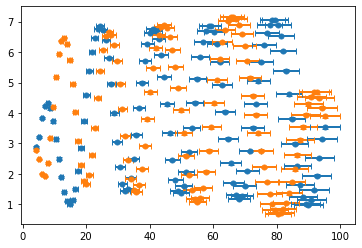

In [52]:
plt.errorbar(v_list,rise_mean,xerr=v_error,yerr=rise_error,fmt='o',ms=5,lw=2,capsize=3)
plt.errorbar(v_list,fall_mean,xerr=v_error, yerr=fall_error,fmt='o',ms=5,lw=2,capsize=3)
#plt.errorbar(volt_fall,fall_max,xerr=volt_fall_error,yerr=fall_max_error,fmt='o',ms=5,lw=2,capsize=3)

<ErrorbarContainer object of 3 artists>

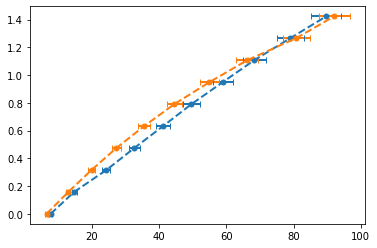

In [53]:
lambd = 633*1e-3 #µm
dl_rise = [(i)*lambd/4 for i in range(len(gauss_rise_mean))]
dl_fall = [(i)*lambd/4 for i in range(len(gauss_fall_mean))]
dl_rise = np.array(dl_rise)

plt.errorbar(gauss_rise_mean,dl_rise,xerr=0.5*gauss_rise_mean/10,fmt='--o',ms=5,lw=2,capsize=3)
plt.errorbar(gauss_fall_mean,dl_rise,xerr=0.5*gauss_fall_mean/10,fmt='--o',ms=5,lw=2,capsize=3)

[0.01841936 7.37216854]
[0.00042461 0.35016045]
7.728051445722538 0.3864025722861269
5.889044536348669 0.3403409246954933


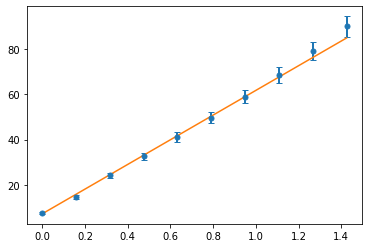

In [56]:
def v_lin_fit(delta_l,d,V_p):
    return delta_l/d+V_p

p_opt, p_cov = curve_fit(v_lin_fit,dl_rise,gauss_rise_mean,p0=[1/20,1], sigma=0.5*gauss_rise_mean/10, absolute_sigma=True)

print(p_opt)
print(np.sqrt(np.diag(p_cov)))

plt.errorbar(dl_rise,gauss_rise_mean,yerr=0.5*gauss_rise_mean/10,fmt='o',ms=5,lw=2,capsize=3)
#plt.errorbar(gauss_rise_mean,dl_rise, xerr=0.5*gauss_rise_mean/10,fmt='o',ms=5,lw=2,capsize=3)
plt.plot(dl_rise,v_lin_fit(dl_rise,p_opt[0],p_opt[1]))

print(gauss_rise_mean[0],0.5*gauss_rise_mean[0]/10)

ch_min = np.sum(((gauss_rise_mean-v_lin_fit(dl_rise, p_opt[0],p_opt[1]))/(0.5*gauss_rise_mean/10))**2)
p_val = chi2.cdf(ch_min,len(gauss_rise_mean)-2)

print(ch_min,p_val)

Fittet værdi af b : 79.28761332438474
Bud på usikkerheden af denne: 0.04547327376150818


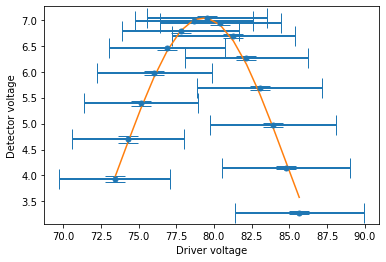

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import odr

x = [73.41597, 74.28949, 75.16302, 76.03654, 76.91006, 77.78359, 78.66019, 79.53371,
 80.40724, 81.28076, 82.15428, 83.0278,  83.9044, 84.77793, 85.65145]
y = [3.9368,4.6951,5.3897,5.9806,6.4481,6.7780,6.9770,7.0344,6.9387,6.6858,6.2662,5.6932,4.9678,4.1469,3.2856,]
x_err = [3.6707,3.7144,3.7581,3.8018,3.8455,3.8891,3.9330,3.9766,4.0203,4.0640,4.1077,4.1513,4.1952,4.2388,4.2825]
y_err = [0.0565,0.0605,0.0533,0.0370,0.0268,0.0260,0.0278,0.0343,0.0406,0.0446,0.0449,0.0390,0.0355,0.0266,0.0260]

guess = [5,80,5] #Et gæt til vores fitte-rutine

def Gauss(p,x): 
    a,b,c = p #a = amp, b = middelværdi, c = varians 
    return a*np.exp(-(x-b)**2/(2*c**2))

#Lav quad model 
quad_model = odr.Model(Gauss)
#Lav realData
data = odr.RealData(x,y,sx=x_err,sy=y_err)
#Setup ODR 
odr_model = odr.ODR(data,quad_model,beta0=guess)
out = odr_model.run() #Kør! 
p_opt = out.beta #Optimale parametre 
p_err = out.sd_beta #Usikkerhed på disse

#out.pprint() <- Hvis du vil have fuldt output fra funktionen! 

print(f'Fittet værdi af b : {p_opt[1]}')
print(f'Bud på usikkerheden af denne: {p_err[1]}')

#Plot all the things! 
plt.errorbar(x,y,xerr=x_err,yerr=y_err,fmt='o',ms=5,lw=2,capsize=10)
plt.plot(x,Gauss(p_opt,x))
plt.xlabel('Driver voltage')
plt.ylabel('Detector voltage')
plt.show()

0
1
clear
0
1
100
0
1
120
0
1
150
0
1
180
0
1
230
0
1
300


Failed to find a Ghostscript installation.  Distillation step skipped.


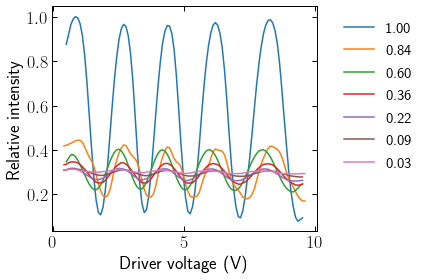

In [192]:
angle_names = ['clear','100','120','150','180','230','300']
N_list = [104,106,104,105,105,105,106]


#angle_names = ['0','100','110','120','140','160','180']
#N_list = [110,110,110,110,110,110,110]

max_ints = []
max_error = []

for t,N,angle_name in zip(T,N_list,angle_names): 
    volts,mean,error,_,_ = mean_several_files(2,f'Int_{angle_name}\Int_{angle_name}',N=N,to_print=False)
    #volts,mean,error,_,_ = mean_several_files(3,f'Dag3\Int{angle_name}\Int{angle_name}',N=N,to_print=True)
    
    print(angle_name)
    max_index = np.argmax(mean)
    max_ints.append(mean[max_index])
    max_error.append(error[max_index])
    
    plt.plot(volts,mean/max_ints[0],label=f'{t:.2f}')
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc=2)
plt.xlabel(r'Driver voltage (V)')
plt.ylabel(r'Relative intensity')
plt.rcParams.update({'figure.autolayout': True})
plt.savefig('Wheel.eps', format='eps')

[8.248240074657863, 3.6612568857335734, 3.3254868446632377, 2.8551718775510206, 2.62402408749609, 2.5899608003440564, 2.584223265835614]
0.04989850819724673
0.04207145789676592
0.02990801307439206
0.01792617211164166
0.010744533439145276
0.004578124108796697
0.0013867161128239026
[[0.04989851 0.04207146 0.02990801 0.01792617 0.01074453 0.00457812
  0.00138672]
 [0.05251913 0.04428101 0.03147876 0.01886764 0.01130883 0.00481856
  0.00145955]]


Failed to find a Ghostscript installation.  Distillation step skipped.


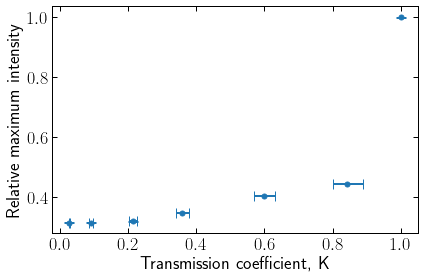

In [214]:
angles = [float(angle) if angle != 'clear' else 90 for angle in angle_names]
angles = np.array(angles)-90
#max_ints[0] /= 2
print(max_ints)
normed_max_int = [intensity/max_ints[0] for intensity in max_ints]

normed_max_error = [val/max_ints[0]*np.sqrt((err/val)**2+(max_error[0]/max_ints[0])**2) for err,val in zip(max_error,max_ints)]
m = 0.00741#0.0148#
T = np.array([10**(-m*theta) for theta in angles])


def error_prop(x,val): 
    error = 3 #deg 
    upper = 10**(-m*(x+error))
    lower = 10**(-m*(x-error))
    print(val-upper)
    return [abs(upper-val),abs(val-lower)]

error = np.array([error_prop(x,val) for x,val in zip(angles,T)]).T
print(error)

plt.errorbar(T[1:],normed_max_int[1:],xerr=error[:,1:],yerr=normed_max_error[1:],fmt='o',ms=5,lw=2,capsize=5)
plt.errorbar(T[0],normed_max_int[0],yerr=normed_max_error[0],fmt='o',ms=5,lw=2,capsize=5,c='C0')
plt.xlabel('Transmission coefficient, K')
plt.ylabel('Relative maximum intensity')
#plt.plot(T_test[1:],rel_test(T_test[1:]))
plt.savefig('KLAMT.eps',format='eps')

In [208]:
print(error)
error[:,1:]

[[0.04989851 0.04207146 0.02990801 0.01792617 0.01074453 0.00457812
  0.00138672]
 [0.05251913 0.04428101 0.03147876 0.01886764 0.01130883 0.00481856
  0.00145955]]


array([[0.04207146, 0.02990801, 0.01792617, 0.01074453, 0.00457812,
        0.00138672],
       [0.04428101, 0.03147876, 0.01886764, 0.01130883, 0.00481856,
        0.00145955]])